# ДЗ по "Сбор и разметка данных (семинары)"
## Семинар 7. Selenium в Python
Домашнее задание:  
1.	Выберите веб-сайт, который содержит информацию, представляющую интерес для извлечения данных. Это может быть новостной сайт, платформа для электронной коммерции или любой другой сайт, который позволяет осуществлять скрейпинг (убедитесь в соблюдении условий обслуживания сайта).  
2.	Используя Selenium, напишите сценарий для автоматизации процесса перехода на нужную страницу сайта.  
3.	Определите элементы HTML, содержащие информацию, которую вы хотите извлечь (например, заголовки статей, названия продуктов, цены и т.д.).  
4.	Используйте BeautifulSoup для парсинга содержимого HTML и извлечения нужной информации из идентифицированных элементов.  
5.	Обработайте любые ошибки или исключения, которые могут возникнуть в процессе скрейпинга.  
6.	Протестируйте свой скрипт на различных сценариях, чтобы убедиться, что он точно извлекает нужные данные.  
7.	Предоставьте ваш Python-скрипт вместе с кратким отчетом (не более 1 страницы), который включает следующее:   
URL сайта. Укажите URL сайта, который вы выбрали для анализа. Описание. Предоставьте краткое описание информации, которую вы хотели извлечь из сайта. Подход. Объясните подход, который вы использовали для навигации по сайту, определения соответствующих элементов и извлечения нужных данных. Трудности. Опишите все проблемы и препятствия, с которыми вы столкнулись в ходе реализации проекта, и как вы их преодолели. Результаты. Включите образец извлеченных данных в выбранном вами структурированном формате (например, CSV или JSON).  

*Примечание: Обязательно соблюдайте условия обслуживания сайта и избегайте чрезмерного скрейпинга, который может нарушить нормальную работу сайта.*

In [24]:
# Устанавливаем пакеты если они не установлены
# !pip install selenium
# !pip install pandas
# !pip install matplotlib
# !pip install pymongo

In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

In [26]:
options = Options()
# Запуск браузера с развернутым экраном
options.add_argument('start-maximized')
# Будем использовать браузер Chrom
driver = webdriver.Chrome(options=options)
# Открываем ссылку
driver.get('https://www.wildberries.ru/')
time.sleep(4)

In [27]:
wait = WebDriverWait(driver, 10)
# Ищем строку поиска
input = wait.until(EC.presence_of_element_located((By.ID, "searchInput")))
# Вводим фразу поиска и нажимаем Enter
input.send_keys('аккумулятор для ибп 12v')
input.send_keys(Keys.ENTER)

### Прокручиваем страницу и записываем все ссылки на аккумуляторы, если есть кнопка "далее" - нажимаем её или выходим из цикла 

In [28]:
# Список ссылок на страницы аккумулятора
url_list = []

while True:
    # Количество аккумуляторов на странице
    count = None
    while True:
        time.sleep(4)
        # Ожидаем появление объекта (html код) карточек товара
        cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//article[@id]')))
        # Выходим из цикла, если при прокрутке страницы, количество товаров не меняется 
        if len(cards) == count:
            break    
        # Вычисляем сколько карточек товара на странице
        count = len(cards)
        # Прокручиваем страницу выполняя JAVA Script
        driver.execute_script('window.scrollBy(0, 1800)')
        time.sleep(2)
        
    # На полностью загруженной странице соберём инфу
    for card in cards:
        # Записываем ссылку каждого аккумулятора
        url = card.find_element(By.XPATH, './div/a').get_attribute('href')
        url_list.append(url)
    
    # Проверяем есть ли кнопка дальше
    try:
        next = driver.find_element(By.XPATH,  "//a[@class='pagination-next pagination__next j-next-page']")
        next.click()
    except Exception:
        break

In [29]:
print(f'Всего получено: {len(url_list)} ссылок на аккумуляторы')

Всего получено: 965 ссылок на аккумуляторы


### Заходим на каждую страницу найденныж аккомуляторов и парсим её

In [30]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import os

# Предположительно, здесь должны быть определены options и url_list
# options =...
# url_list =...

driver2 = webdriver.Chrome(options=options)
wait2 = WebDriverWait(driver2, 10)
acb_list = []

# Просматриваем все ссылки на аккумуляторы
for url_item in url_list:
    # Проверяем, есть ли на странице элемент с классом sold-out-product__text
    driver2.get(url_item)
    sold_out_elements = driver2.find_elements(By.CLASS_NAME, 'sold-out-product__text')

    # Если такой элемент есть, пропускаем обработку этой страницы
    if len(sold_out_elements) > 0:
        print(f"Пропускаем {url_item}, так как товар недоступен")
        continue

    acb_dict = {}

    # Заносим название аккумулятора
    acb_dict['name'] = wait2.until(
        EC.presence_of_element_located((By.XPATH, "//h1"))).text
    # Заносим цену аккумулятора
    price = wait2.until(EC.presence_of_all_elements_located(
        (By.CLASS_NAME, 'price-block__price')))
    try:
        acb_dict['price'] = float(re.sub(r'[^\d.]+', '', price[1].text))
    except Exception:
        acb_dict['price'] = None
    # Заносим бренд аккумулятора
    acb_dict['brend'] = wait2.until(EC.presence_of_element_located(
        (By.CLASS_NAME, "product-page__header-brand"))).text
    # Заносим url ссылку на аккумулятор
    acb_dict['url'] = url_item

    # Обрабатываем табличные данные
    table_label = wait2.until(
        EC.presence_of_all_elements_located((By.XPATH, '//th')))
    table_param = wait2.until(
        EC.presence_of_all_elements_located((By.XPATH, '//td')))
    # Заносим данные в зависимости от названия
    for i in range(len(table_label)):
        if table_label[i].text == 'Страна производства':
            acb_dict['country'] = table_param[i].text
        elif table_label[i].text == 'Емкость аккумулятора (Ач)':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['capacity'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['capacity'] = None
        elif table_label[i].text == 'Напряжение':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['voltage'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['voltage'] = None

    # Добавляем словарь в список аккумуляторов
    acb_list.append(acb_dict)

    # Выводим информацию о добавленном аккумуляторе
    
    print("Добавлен аккумулятор:")
    # print(acb_dict)
    print(acb_dict['name'])

# Закрытие драйвера после завершения работы
driver2.quit()

Добавлен аккумулятор:
Аккумулятор 12V DTM 1207
Добавлен аккумулятор:
Аккумулятор 12v 7ah акб agm 1207
Добавлен аккумулятор:
Аккумулятор для ибп 12v 80 Ah M6 котлов, поломоечных машин
Добавлен аккумулятор:
Аккумулятор ибп 12v 40Ah M6/T14 котлов и насосов отопления
Добавлен аккумулятор:
Аккумулятор для ибп 12v 5Ah F2/T2 фонариков, весов, эхолотов
Добавлен аккумулятор:
Аккумулятор для ибп 12v 7.2 Ah T1 радиоуправляемой машинки
Добавлен аккумулятор:
Аккумулятор ибп 12v 7.5 Ah F2/T2 детской машинки, мотоцикла
Добавлен аккумулятор:
Аккумулятор для ибп 12v 7.2 Ah T2 детского мотоцикла, машины
Добавлен аккумулятор:
Аккумулятор для ибп 12v 76 Ah поломоек, автодомов, лодок
Добавлен аккумулятор:
Аккумулятор для бесперебойника GEL 12V 100 Ач
Добавлен аккумулятор:
Аккумулятор для бесперебойника GP 12V 120 Ач
Добавлен аккумулятор:
Аккумулятор 12v 1.3 Ah F1/T1 для эхолота, весов, игрушек
Добавлен аккумулятор:
Аккумулятор для бесперебойника GEL 12V 75 Ач
Добавлен аккумулятор:
Аккумулятор для ибп 12v 1

In [31]:
print(f'Обработано {len(acb_list)} страниц')

Обработано 965 страниц


### Посмотрим, что за данные мы получили

In [32]:
df = pd.DataFrame(acb_list)
df.head()

,name,price,brend,url,voltage,country,capacity
0,Аккумулятор 12V DTM 1207,1868.00,DELTA BATTERY,https://www.wildberries.ru/catalog/40724193/de...,12.00,Китай,7.20
1,Аккумулятор 12v 7ah акб agm 1207,1138.00,Etalon,https://www.wildberries.ru/catalog/149737382/d...,12.00,Китай,7.00
2,"Аккумулятор для ибп 12v 80 Ah M6 котлов, полом...",NaN,NPP,https://www.wildberries.ru/catalog/214740446/d...,12.00,Китай,80.00
3,Аккумулятор ибп 12v 40Ah M6/T14 котлов и насос...,NaN,Thomas,https://www.wildberries.ru/catalog/194125714/d...,12.00,Китай,40.00
4,"Аккумулятор для ибп 12v 5Ah F2/T2 фонариков, в...",902950.00,NPP,https://www.wildberries.ru/catalog/194125699/d...,12.00,Китай,5.00


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      965 non-null    object 
 1   price     963 non-null    float64
 2   brend     965 non-null    object 
 3   url       965 non-null    object 
 4   voltage   859 non-null    float64
 5   country   841 non-null    object 
 6   capacity  858 non-null    float64
dtypes: float64(3), object(4)
memory usage: 52.9+ KB


### Какие производители аккумуляторов для ИБП представлены на Wildberries

In [34]:
data = df['country'].value_counts()
names = data.index
values = data.values
data

country
Китай       774
Вьетнам      42
Россия        7
Тайвань       7
Польша        6
Словения      4
中国            1
Name: count, dtype: int64

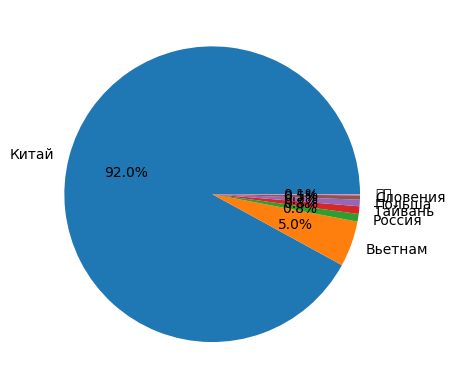

In [36]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    plt.pie(values, autopct='%.1f%%', labels=names)
    plt.show()

### Минимальная, максимальная и средняя цена аккумулятора в зависимости от его ёмкости

In [37]:
df.groupby('capacity').agg({'price': ['min', 'mean', 'max']})

price                            
                   min          mean           max
capacity                                          
0.80         646680.00    5554968.60   11141173.00
1.20         488514.00    3110898.80   11641226.00
1.30         672708.00    3597406.38   12921361.00
2.20         677713.00    5123536.83   12141278.00
2.30         737776.00    3503185.85   15201601.00
...                ...           ...           ...
120.00   1587616712.00 1743985024.67 1872519711.00
150.00   2223723408.00 2252248708.00 2310424320.00
200.00   2815029632.00 3351410278.00 4390046211.00
5000.00    14821560.00   14821560.00   14821560.00
40000.00 1088411457.00 1088411457.00 1088411457.00

[63 rows x 3 columns]

### Топ 10 популярных компаний

In [38]:
data = df['brend'].value_counts()
names = data.index
values = data.values
data.head(10)

brend
DELTA BATTERY       167
General Security     55
CSB                  44
ZUBR                 42
NPP                  40
Kiper Power          40
Alfa Battery         37
LEOCH                37
Security Force       34
Sunways              29
Name: count, dtype: int64

### Запишем полученные данные в БД MongoDB

In [39]:
from pymongo import MongoClient

In [40]:
# Подключение к серверу MongoDB
client = MongoClient('mongodb://localhost:27017/')
# Выбор базы данных и коллекции
db = client['acb']
collection = db['acb_12v']

In [42]:
# Отправим данные в БД MongoDB
collection.insert_many(acb_list)

InsertManyResult([ObjectId('664e024df14c2d947dbc8fa3'), ObjectId('664e024df14c2d947dbc8fa4'), ObjectId('664e024df14c2d947dbc8fa5'), ObjectId('664e024df14c2d947dbc8fa6'), ObjectId('664e024df14c2d947dbc8fa7'), ObjectId('664e024df14c2d947dbc8fa8'), ObjectId('664e024df14c2d947dbc8fa9'), ObjectId('664e024df14c2d947dbc8faa'), ObjectId('664e024df14c2d947dbc8fab'), ObjectId('664e024df14c2d947dbc8fac'), ObjectId('664e024df14c2d947dbc8fad'), ObjectId('664e024df14c2d947dbc8fae'), ObjectId('664e024df14c2d947dbc8faf'), ObjectId('664e024df14c2d947dbc8fb0'), ObjectId('664e024df14c2d947dbc8fb1'), ObjectId('664e024df14c2d947dbc8fb2'), ObjectId('664e024df14c2d947dbc8fb3'), ObjectId('664e024df14c2d947dbc8fb4'), ObjectId('664e024df14c2d947dbc8fb5'), ObjectId('664e024df14c2d947dbc8fb6'), ObjectId('664e024df14c2d947dbc8fb7'), ObjectId('664e024df14c2d947dbc8fb8'), ObjectId('664e024df14c2d947dbc8fb9'), ObjectId('664e024df14c2d947dbc8fba'), ObjectId('664e024df14c2d947dbc8fbb'), ObjectId('664e024df14c2d947dbc8f

## Вывод:
Взял информацию с сайта `https://www.wildberries.ru/` об аккумуляторах 12V для ИБП. С помощью скрипта ввёл информацию для поиска, после чего скрипт прокручивал страницу, чтобы загрузились все товары. Далее сохранял все ссылки на аккумуляторы в список и если присутствовала кнопка далее, скрипт нажимал её.
После того как были собраны все ссылки на аккумуляторы, в другом окне браузера открывалась каждая ссылка и извлекались следующие данные:  
- марка;
- напряжение аккумулятора;
- ёмкость аккумулятора;
- бренд;
- страна производитель;
- цена;
- url.
  
Сначала хотел забирать данные с `OnlineTrade.ru` но сайт понял, что я робот и начал задавать различные задания - типа поверните картинку в правильном положении, поэтому перешел на `https://www.wildberries.ru/`. Все параметры (таймауты, число пикселей прокрутки и т.д.) подбирал экспериментальным путём. Отлаживал программу частично в PyCharm Profecional (демо версия), частично в Jupiter Notebook.

Для автоматического сбора данных, нажмите в Jupiter Notebook -> выполнить все (`Run All Cells`)